### Fraud Analytics - C66890
### ASSIGNMENT 4
### Team Members
- Manikanta Vallepu - AI20BTECH11014
- Jarupula Saikumar - CS21BTECH11023
- Vignan Kota - CS21BTECH11029
- Sahil Chandra - CS20BTECH11033
- Kalala Abhinav - CO21BTECH11007

## Autoencoder Implementation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,  roc_curve, precision_recall_curve, auc
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('creditcard.csv')

data.isnull().values.any()

False

## Class Wise Analysis

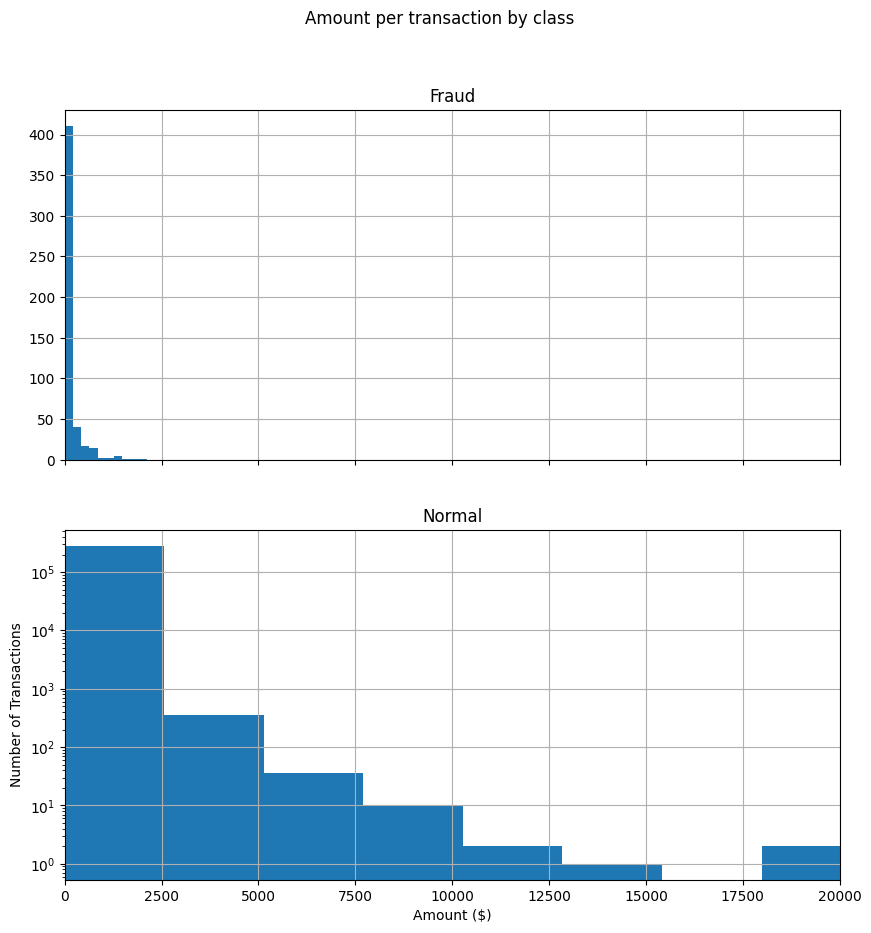

In [4]:
normal = data[data['Class']==0]
fraud = data[data['Class']==1]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10,10) )
f.suptitle('Amount per transaction by class')

bins = 10

ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

ax1.grid()
ax2.grid()
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


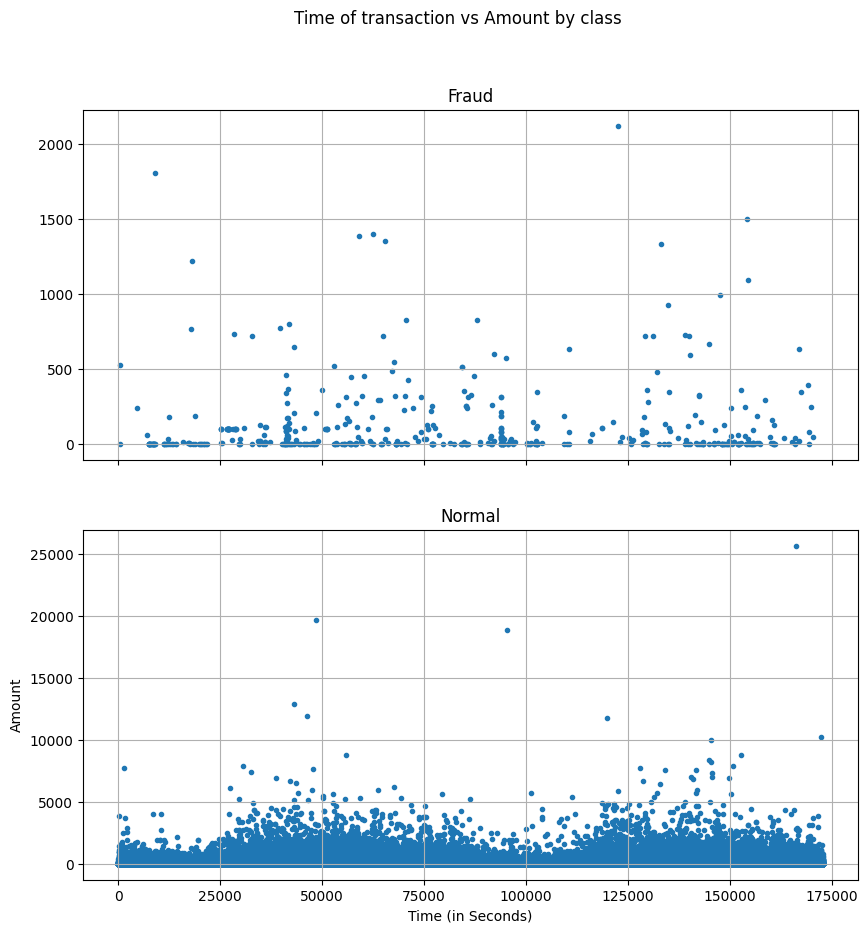

In [5]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud.Time, fraud.Amount, marker='.')
ax1.set_title('Fraud')
ax1.grid()
ax2.scatter(normal.Time, normal.Amount, marker='.')
ax2.set_title('Normal')
ax2.grid()
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


In [6]:

# Remove Time as it is non-dependent
data = data.drop('Time', axis=1)


In [7]:

# Separate features and labels
y = data['Class']
X = data.drop('Class', axis=1)

# Preprocessing
# Convert amount feature into log scale
data['Amount'] = np.log1p(data['Amount'])

# Separate features and labels
X = data.drop('Class', axis=1)
y = data['Class']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:

# Define the input shape

# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 15  # Example, adjust based on experimentation
hidden_dim = 7  # Example, adjust based on experimentation

# Define the encoder part of the autoencoder
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
encoder_layer = Dense(hidden_dim, activation='relu')(encoder_layer)

# Define batch normalization layer
normalized = BatchNormalization()(encoder_layer)

# Define dropout layer
dropped = Dropout(0.2)(normalized)

# Define the decoder part of the autoencoder
decoder_layer = Dense(encoding_dim, activation='relu')(encoder_layer)
decoder_layer = Dense(input_dim, activation='sigmoid')(decoder_layer)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder_layer)


In [10]:

# Define learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with optimizer and loss function
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# Train the autoencoder
history = autoencoder.fit(X_train, X_train,
                          epochs=10,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=[early_stopping],
                          verbose=1)


Epoch 1/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 3s 732us/step - loss: 0.9409 - val_loss: 0.8410
Epoch 2/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step - loss: 0.8379 - val_loss: 0.8253
Epoch 3/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 2s 627us/step - loss: 0.8300 - val_loss: 0.8148
Epoch 4/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - loss: 0.8006 - val_loss: 0.8054
Epoch 5/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step - loss: 0.8176 - val_loss: 0.8020
Epoch 6/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 2s 671us/step - loss: 0.8029 - val_loss: 0.8001
Epoch 7/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 2s 664us/step - loss: 0.8105 - val_loss: 0.7984
Epoch 8/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 3s 754us/step - loss: 0.8112 - val_loss: 0.7968
Epoch 9/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 3s 825us/step - loss: 0.8017 - val_loss: 0.7958
Epoch 10/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 3s 886us/step - loss: 0.7923 - val_loss: 0.7935


# Results

In [11]:
# Evaluate the model
decoded_data = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - decoded_data, 2), axis=1)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step


mse here is basically the reconstruction error, if the model has learned the normal datapoints well, then this error should be less on normal points, and high on fraud points.

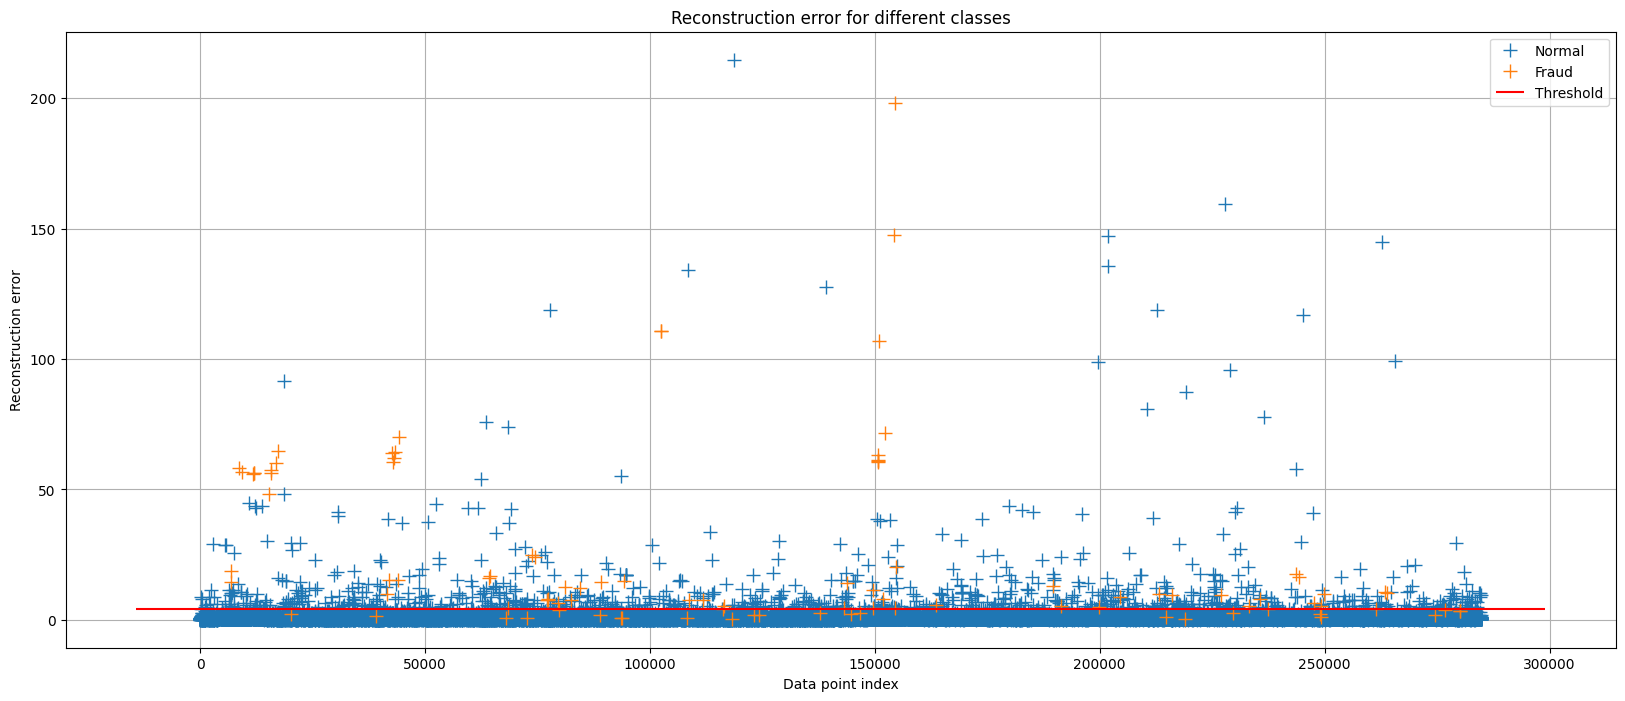

In [12]:
threshold = np.mean(mse) + np.std(mse)

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class':y_test})
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize = (20,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='+', ms=10, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.grid()
plt.show()


In [13]:

# Prediction scores
predictions = (mse > threshold).astype(int)


# Calculate TP, TN, FP, FN
TP = sum((predictions == 1) & (y_test == 1))
TN = sum((predictions == 0) & (y_test == 0))
FP = sum((predictions == 1) & (y_test == 0))
FN = sum((predictions == 0) & (y_test == 1))

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

print(classification_report(y_test, predictions))


True Positives: 73
True Negatives: 55961
False Positives: 903
False Negatives: 25
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.74      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.86      0.56     56962
weighted avg       1.00      0.98      0.99     56962



The model achieved high recall for positive cases, indicating its ability to effectively identify instances of fraud.

The model exhibits a high true positive rate, demonstrating its effectiveness in detecting instances of fraud. 

Additionally, the weighted average precision for positive cases suggests a robust performance in identifying fraudulent transactions.

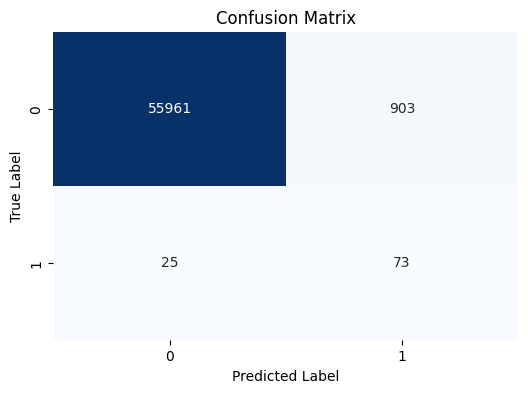

In [16]:
import seaborn as sns

# Confusion Matrix
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_test, predictions)

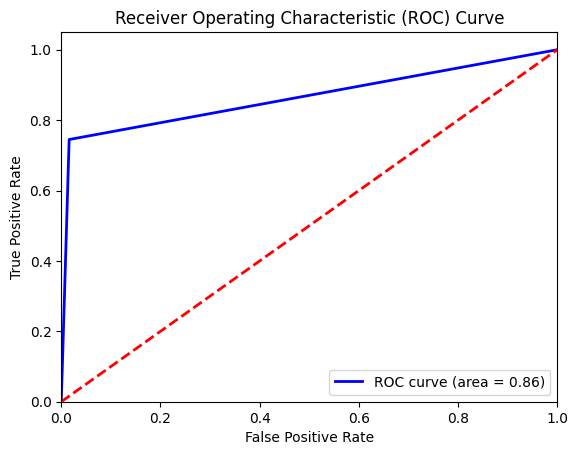

In [18]:

# ROC Curve
def plot_roc_curve(true_labels, predicted_probabilities):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curve
plot_roc_curve(y_test, predictions)

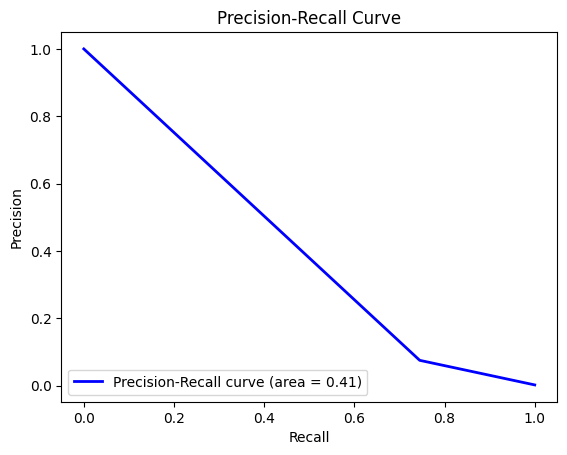

In [19]:

# Precision-Recall Curve
def plot_precision_recall_curve(true_labels, predicted_probabilities):
    precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probabilities)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Plot Precision-Recall Curve
plot_precision_recall_curve(y_test, predictions)
